## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

In [2]:
def perform_action(amp, shots=1, target='1'):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    for ind, angle in enumerate(angles):
        if target == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch

        elif target == '+':
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target == '-':
            qc.ry(2 * np.pi * angle, 0)
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0)
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key


        #  Calculate reward
        if target == '1':
            np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))

        qc.clear()

    return reward_table

#### Set Hyperparameters for the RL

In [3]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator()  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 100
batch_size = 50
eta = 0.01  # Learning rate for policy update step

# Policy parameters
mu = nn.Parameter(torch.randn([]) * 0.05)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
sigma = nn.Parameter(torch.tensor(0.05))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

#### Training

In [4]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3

def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for i in tqdm(range(n_epochs)):
    print('\nEPOCH', i+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward = perform_action(action, shots=1, target='-')
    #reward = perform_action(action, shots=1)
    print("Average Return:", reward.mean().item())

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)

  4%|▍         | 4/100 [00:00<00:02, 38.13it/s]


EPOCH 1
Policy parameter
mu = 0.022678192704916 +- sigma = 0.05000000074505806
baseline 0.0
Average Return: -0.04

EPOCH 2
Policy parameter
mu = 0.012678193859755993 +- sigma = 0.04000000283122063
baseline -0.009999996051192284
Average Return: 0.08

EPOCH 3
Policy parameter
mu = 0.002698601223528385 +- sigma = 0.02998817339539528
baseline -0.020001348108053207
Average Return: -0.04

EPOCH 4
Policy parameter
mu = -0.007298714481294155 +- sigma = 0.02228417433798313
baseline -0.030005618929862976
Average Return: 0.16

EPOCH 5
Policy parameter
mu = -0.01634540781378746 +- sigma = 0.022177230566740036
baseline -0.03948358818888664
Average Return: 0.36

EPOCH 6
Policy parameter
mu = -0.024400124326348305 +- sigma = 0.01905166544020176
baseline -0.04857439920306206
Average Return: 0.2

EPOCH 7
Policy parameter
mu = -0.03193643316626549 +- sigma = 0.01934276893734932
baseline -0.05798216536641121
Average Return: 0.2

EPOCH 8
Policy parameter
mu = -0.04007857292890549 +- sigma = 0.01786953955

 19%|█▉        | 19/100 [00:00<00:01, 61.74it/s]

Average Return: 0.16

EPOCH 12
Policy parameter
mu = -0.06885427981615067 +- sigma = 0.008099195547401905
baseline -0.10348479449748993
Average Return: 0.32

EPOCH 13
Policy parameter
mu = -0.0727984830737114 +- sigma = 0.00815390981733799
baseline -0.11224724352359772
Average Return: 0.52

EPOCH 14
Policy parameter
mu = -0.07380722463130951 +- sigma = 0.008460020646452904
baseline -0.12080596387386322
Average Return: 0.52

EPOCH 15
Policy parameter
mu = -0.07643616199493408 +- sigma = 0.009410418570041656
baseline -0.12980706989765167
Average Return: 0.52

EPOCH 16
Policy parameter
mu = -0.0804181694984436 +- sigma = 0.010886747390031815
baseline -0.13881947100162506
Average Return: 0.56

EPOCH 17
Policy parameter
mu = -0.08467508107423782 +- sigma = 0.010610480792820454
baseline -0.14733515679836273
Average Return: 0.48

EPOCH 18
Policy parameter
mu = -0.08681679517030716 +- sigma = 0.011270571500062943
baseline -0.15550509095191956
Average Return: 0.64

EPOCH 19
Policy parameter
mu 

 35%|███▌      | 35/100 [00:00<00:00, 67.45it/s]

Average Return: 0.64

EPOCH 26
Policy parameter
mu = -0.09508759528398514 +- sigma = 0.0
baseline -0.21704694628715515
Average Return: 0.72

EPOCH 27
Policy parameter
mu = -0.09373298287391663 +- sigma = 0.0
baseline -0.22316743433475494
Average Return: 0.68

EPOCH 28
Policy parameter
mu = -0.09100756794214249 +- sigma = 0.00017067743465304375
baseline -0.22891363501548767
Average Return: 0.44

EPOCH 29
Policy parameter
mu = -0.08862139284610748 +- sigma = 0.0017781014321371913
baseline -0.2342243790626526
Average Return: 0.36

EPOCH 30
Policy parameter
mu = -0.08637441694736481 +- sigma = 0.0017673429101705551
baseline -0.23929163813591003
Average Return: 0.48

EPOCH 31
Policy parameter
mu = -0.08490212261676788 +- sigma = 0.0004419139586389065
baseline -0.2442462146282196
Average Return: 0.44

EPOCH 32
Policy parameter
mu = -0.08426280319690704 +- sigma = 0.0005195471458137035
baseline -0.248945415019989
Average Return: 0.56

EPOCH 33
Policy parameter
mu = -0.08366186916828156 +- sig

 49%|████▉     | 49/100 [00:00<00:00, 67.47it/s]

Average Return: 0.44

EPOCH 41
Policy parameter
mu = -0.08556215465068817 +- sigma = 0.015787355601787567
baseline -0.2899389863014221
Average Return: 0.48

EPOCH 42
Policy parameter
mu = -0.08842075616121292 +- sigma = 0.015728279948234558
baseline -0.2959379255771637
Average Return: 0.6

EPOCH 43
Policy parameter
mu = -0.0913865938782692 +- sigma = 0.01439506746828556
baseline -0.3022749423980713
Average Return: 0.52

EPOCH 44
Policy parameter
mu = -0.09342969954013824 +- sigma = 0.014401705004274845
baseline -0.3088909685611725
Average Return: 0.6

EPOCH 45
Policy parameter
mu = -0.09368853271007538 +- sigma = 0.014470459893345833
baseline -0.316184401512146
Average Return: 0.72

EPOCH 46
Policy parameter
mu = -0.09478645771741867 +- sigma = 0.013422966003417969
baseline -0.32345229387283325
Average Return: 0.48

EPOCH 47
Policy parameter
mu = -0.09621530771255493 +- sigma = 0.013755407184362411
baseline -0.3305516541004181
Average Return: 0.6

EPOCH 48
Policy parameter
mu = -0.0980

 64%|██████▍   | 64/100 [00:00<00:00, 68.77it/s]

Average Return: 0.76

EPOCH 55
Policy parameter
mu = -0.12361355125904083 +- sigma = 0.025770926848053932
baseline -0.39534908533096313
Average Return: 0.72

EPOCH 56
Policy parameter
mu = -0.12713506817817688 +- sigma = 0.02662091888487339
baseline -0.4035520553588867
Average Return: 0.88

EPOCH 57
Policy parameter
mu = -0.12872205674648285 +- sigma = 0.027072761207818985
baseline -0.4118114411830902
Average Return: 0.84

EPOCH 58
Policy parameter
mu = -0.13063214719295502 +- sigma = 0.028706727549433708
baseline -0.4202892482280731
Average Return: 0.8

EPOCH 59
Policy parameter
mu = -0.13254044950008392 +- sigma = 0.028880290687084198
baseline -0.42834338545799255
Average Return: 0.68

EPOCH 60
Policy parameter
mu = -0.1353299468755722 +- sigma = 0.028127461671829224
baseline -0.4371609687805176
Average Return: 0.76

EPOCH 61
Policy parameter
mu = -0.1384177803993225 +- sigma = 0.026261160150170326
baseline -0.44622519612312317
Average Return: 0.76

EPOCH 62
Policy parameter
mu = -0.

 79%|███████▉  | 79/100 [00:01<00:00, 69.33it/s]

Average Return: 0.88

EPOCH 69
Policy parameter
mu = -0.1727309226989746 +- sigma = 0.023723844438791275
baseline -0.5112282037734985
Average Return: 0.84

EPOCH 70
Policy parameter
mu = -0.1773582100868225 +- sigma = 0.024478929117321968
baseline -0.5193343162536621
Average Return: 1.0

EPOCH 71
Policy parameter
mu = -0.18065325915813446 +- sigma = 0.026245396584272385
baseline -0.5270209908485413
Average Return: 0.8

EPOCH 72
Policy parameter
mu = -0.18202555179595947 +- sigma = 0.02815832570195198
baseline -0.5346301794052124
Average Return: 0.96

EPOCH 73
Policy parameter
mu = -0.18322591483592987 +- sigma = 0.031163599342107773
baseline -0.5417274236679077
Average Return: 0.92

EPOCH 74
Policy parameter
mu = -0.18353717029094696 +- sigma = 0.03272705525159836
baseline -0.5484793186187744
Average Return: 0.92

EPOCH 75
Policy parameter
mu = -0.1852635145187378 +- sigma = 0.03472263738512993
baseline -0.5547628402709961
Average Return: 0.92

EPOCH 76
Policy parameter
mu = -0.1867713

 93%|█████████▎| 93/100 [00:01<00:00, 69.22it/s]

Average Return: 0.88

EPOCH 84
Policy parameter
mu = -0.20838315784931183 +- sigma = 0.06592404842376709
baseline -0.5919772386550903
Average Return: 0.84

EPOCH 85
Policy parameter
mu = -0.21428076922893524 +- sigma = 0.0674561858177185
baseline -0.5929903388023376
Average Return: 0.92

EPOCH 86
Policy parameter
mu = -0.21808400750160217 +- sigma = 0.06921802461147308
baseline -0.5925409197807312
Average Return: 0.8

EPOCH 87
Policy parameter
mu = -0.22153519093990326 +- sigma = 0.06948048621416092
baseline -0.591622531414032
Average Return: 0.96

EPOCH 88
Policy parameter
mu = -0.22396816313266754 +- sigma = 0.06852997094392776
baseline -0.590571403503418
Average Return: 0.92

EPOCH 89
Policy parameter
mu = -0.22692038118839264 +- sigma = 0.06652388721704483
baseline -0.5893040895462036
Average Return: 0.88

EPOCH 90
Policy parameter
mu = -0.22800719738006592 +- sigma = 0.06484082341194153
baseline -0.5872697234153748
Average Return: 0.96

EPOCH 91
Policy parameter
mu = -0.2275867760

100%|██████████| 100/100 [00:01<00:00, 66.91it/s]

Average Return: 0.96

EPOCH 98
Policy parameter
mu = -0.24482415616512299 +- sigma = 0.030987238511443138
baseline -0.5746772289276123
Average Return: 1.0

EPOCH 99
Policy parameter
mu = -0.2487407773733139 +- sigma = 0.02581341564655304
baseline -0.5742598176002502
Average Return: 1.0

EPOCH 100
Policy parameter
mu = -0.2517956793308258 +- sigma = 0.022433210164308548
baseline -0.574081540107727
Average Return: 1.0


#### Visualization

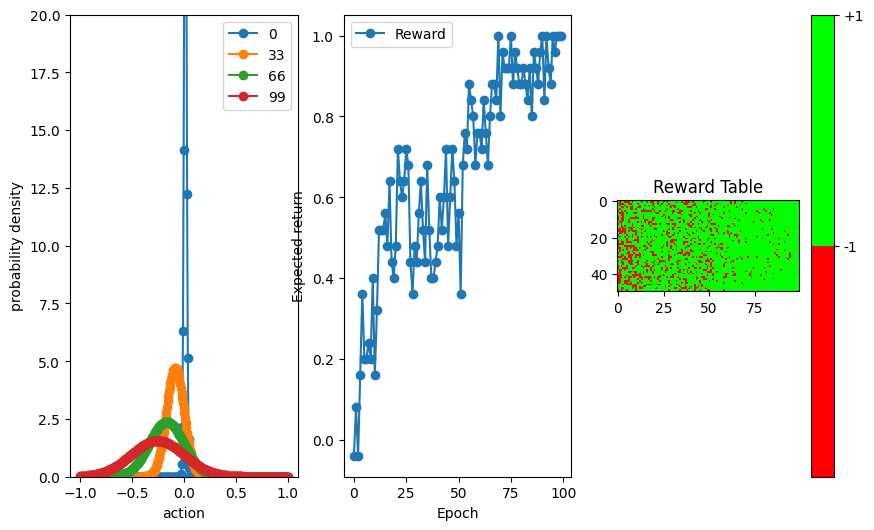

In [5]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel("action")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expected return")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()